#### <b>1. 녹내장 이미지 학습을 위한 데이터 분류</b>

* 이미지를 분류하기 위해 디렉터리를 생성하고 필요한 함수를 정의합니다.

#### <b>2. PyTorch를 이용한 전이 학습(Transfer Learning)</b>

* 전이 학습(transfer learning)의 동작 과정을 간략화한 것은 다음과 같습니다.

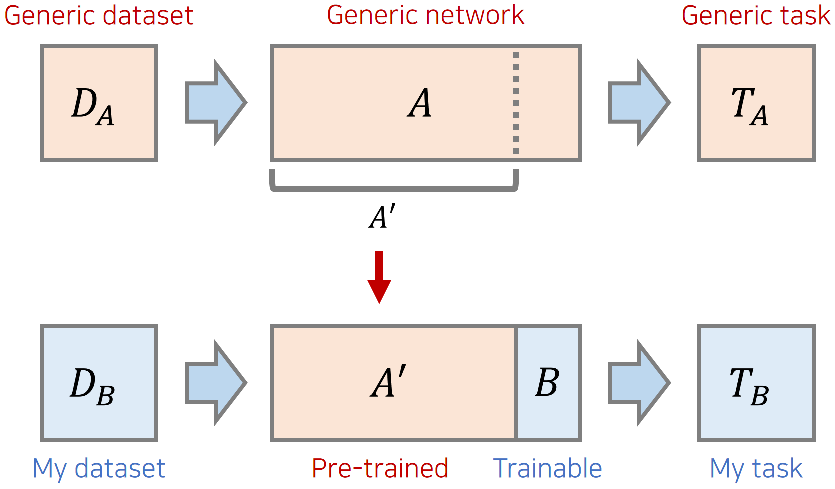

* 학습을 위해 필요한 라이브러리를 불러옵니다.

In [1]:
import os
import time
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import datasets, models, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

* 데이터셋을 불러옵니다.

In [2]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

data_dir = './512resized_images'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 3168
테스트 데이터셋 크기: 792
클래스: ['0', '1', '2']


* 간단히 이미지를 시각화해 봅시다.

In [3]:
# # 이미지 파일이 있는 폴더 경로 설정
# folder_path = './512resized_images/train/0/'  # 실제 폴더 경로로 변경해야 합니다
# 
# # 폴더 내의 이미지 파일 목록 가져오기
# image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg'))]
# 
# # 네 개의 이미지를 출력하기 위한 서브플롯 설정 (2x2 그리드)
# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# 
# # 폴더 내의 이미지를 불러와서 출력
# for i in range(4):  # 네 개의 이미지만 출력
#     if i < len(image_files):
#         image_path = os.path.join(folder_path, image_files[i])  # 이미지 파일의 전체 경로
#         img = Image.open(image_path)  # 이미지 로드
#         row = i // 2
#         col = i % 2
#         axes[row, col].imshow(img)
#         axes[row, col].set_title(image_files[i])
#         axes[row, col].axis('off')  # 이미지 축 숨기기
# 
# # 빈 서브플롯 제거
# for i in range(4, len(image_files)):
#     axes[row, col].axis('off')
# 
# # 그림 출력
# plt.tight_layout()
# plt.show()

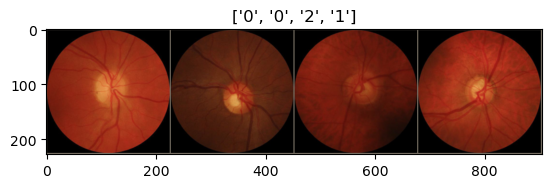

In [4]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()

# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

* 학습할 CNN 딥러닝 모델 객체를 초기화합니다.

In [5]:
model = models.resnet34(pretrained=False)
print(model)

/Users/hansanghyeon/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hansanghyeon/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
num_features = model.fc.in_features

# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

* 학습을 진행합니다.

In [7]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    
    # 학습 과정 중에 결과 출력
    print('# {} Loss: {:.4f} | Acc: {:.4f}% | Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() - start_time))

# 1 Loss: 1.2408 | Acc: 38.0682% | Time: 325.0629s
# 2 Loss: 1.1553 | Acc: 43.5606% | Time: 668.0852s
# 3 Loss: 1.0687 | Acc: 47.0960% | Time: 1016.8754s
# 4 Loss: 1.0387 | Acc: 49.2740% | Time: 1362.5724s
# 5 Loss: 0.9937 | Acc: 52.8093% | Time: 1709.7368s
# 6 Loss: 0.9665 | Acc: 53.5985% | Time: 2055.5070s
# 7 Loss: 0.9389 | Acc: 55.7450% | Time: 2403.4365s
# 8 Loss: 0.9240 | Acc: 58.1439% | Time: 2752.7683s
# 9 Loss: 0.8931 | Acc: 58.0177% | Time: 3100.9352s
# 10 Loss: 0.8517 | Acc: 61.8056% | Time: 3448.8576s
# 11 Loss: 0.8090 | Acc: 64.4571% | Time: 3800.3091s
# 12 Loss: 0.7710 | Acc: 66.1301% | Time: 4152.4642s
# 13 Loss: 0.7315 | Acc: 68.6237% | Time: 4506.0721s
# 14 Loss: 0.6561 | Acc: 72.5063% | Time: 4837.4675s
# 15 Loss: 0.6364 | Acc: 73.0429% | Time: 5167.7890s
# 16 Loss: 0.6045 | Acc: 75.2210% | Time: 5499.6901s
# 17 Loss: 0.5545 | Acc: 77.2412% | Time: 5831.6020s
# 18 Loss: 0.4889 | Acc: 80.3662% | Time: 6161.8216s
# 19 Loss: 0.4564 | Acc: 82.8598% | Time: 6492.8763s
# 20

* 학습된 모델을 평가합니다.

In [8]:
model.eval()
start_time = time.time()

# 모델을 평가할 때 사용할 변수 초기화
y_true = []  # 실제 레이블을 저장할 리스트
y_pred = []  # 모델의 예측 결과를 저장할 리스트

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 실제 레이블과 모델의 예측 결과를 리스트에 추가
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        # print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        # imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

[Test Phase] Loss: 0.2538 Acc: 92.0455% Time: 51.7365s


---
### 성능 평가 지표

In [0]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score

In [27]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Multi-Class Accuracy: {accuracy * 100:.2f}%")

Multi-Class Accuracy: 92.05%


In [22]:
# classification_report 출력
target_names = class_names
print("Classification Report")
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       264
           1       0.91      0.97      0.94       264
           2       0.92      0.93      0.92       264

    accuracy                           0.92       792
   macro avg       0.92      0.92      0.92       792
weighted avg       0.92      0.92      0.92       792


### Multi-Confusion matrix
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FYz4fi%2Fbtqyd71KPB4%2F5B95l7uJvIT8eheYMyd2A1%2Fimg.png" width="1000" height="606">

In [19]:
# confusion_matrix 출력
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm, '\n')

Confusion Matrix:
[[227  16  21]
 [  7 257   0]
 [ 10   9 245]] 


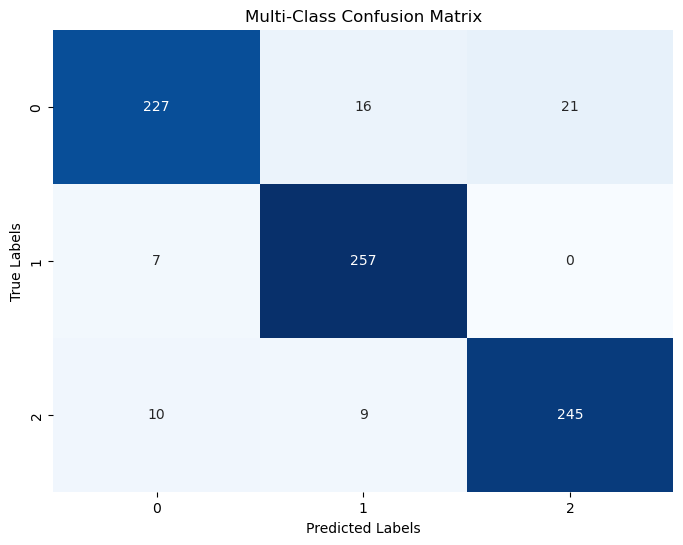

In [28]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Multi-Class Confusion Matrix")
plt.show()

In [14]:
# 카파 통계량 계산
kappa = cohen_kappa_score(y_true, y_pred)

print(f'Cohen\'s Kappa: {kappa:.4f}')

Cohen's Kappa: 0.8807


---

In [0]:
# import tensorflow as tf
# 
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [10]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,